# Calcium imaging

<div class="alert alert-block alert-info">


### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Davide Spalla, Melisa Maidana Capitan


**In this lesson you will learn:**
- point 1
- point 2 ...



***Note boxes templates***:

<div class="alert alert-block alert-info">

### GENERAL NOTE

Use this box for a general note on a topic that is lateral to the lessons's flow, but worth talikng about. 

<div class="alert alert-block alert-success"> 

### TIP  

Use this box for a tip or a small suggestion


<div class="alert alert-block alert-warning"> 

### WARNING  

Use this box for a warning about a common error or a difficult concept

## Introduction
---
A genetically enconded calcium indicator is inyected (GCaMP) so a fluorescence signal is emited when there is change in calcium concentration. Influx and outflux of calcium molecules in cells are related to the generation of spikes, so in that sense fluorecence is related to firing rate of neurons. We can capture that fluorecence with a microscope. 

There are two main microscopy techniques for detecting calcium fluorecence, *1-photon*   (confocal microscopes use 1-photon microscopy technique) and *2-photon microscopy*, but nowadays there are trials for using even *3-photon* imaging. The use of one or the other imaging technique will depend on the specific scientific questions of the experimenter and the available resourses. 

On the one hand, miniendoscopes (small microscopes with 1-photon technology) are portable and can be use in freely moving animals, while (with the current technologies) 2-photon microscopy requires a laser setup where the animal need to be head fixed (and demands muchs higher experimental costs). On the other hand, excitation plane of 2-photon microscopy is much well define as tissue emited light intensity decays as 1/I^2 from the focal plane, while it decays slower with 1-photon microscopy. This last fact makes it harded to create an apropiate pre-processing algorithm to extract calcium fluctuaction (because background also includes activity from different cells in other focal planes).  

We will work on a fragment of a decoded video from **Inscopixs** miniscope (1-photon imaging). This videos have an original sampling rate of $20$Hz, but had been downsample to $10$Hz. The videos are $500$ frames lenght so the algoritms should be runnable in a personal laptop. In the data folder there are multiple examples of videos which will be used in later exercises for multitrial analysis as well as some already source extracted files.

First we will work with one complete video. The entire **FOV** (field of view) from the microscope is saved in file *calcium_video.tif*, while the file *calcium_video_trial_0.tif* has the cropped **ROI** (region of interest) we will work with.  

## Calcium imaging pipeline with CaImAn
---


In [33]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle
import psutil
import logging
from pathlib import Path
import os


import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import code.auxiliary_functions as aux

import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)


In [2]:
input_tif_file_path_FOV = 'data/calcium_video.tif'   # define the path of the raw FOV movie
if not os.path.isfile(input_tif_file_path_FOV):                     # verify that the file exist
    logging.error('Calcium video file not found.')

input_tif_file_path = 'data/caiman_video_trial_0.tif'   # define the path of the raw ROI movie
if not os.path.isfile(input_tif_file_path):                            # verify that the file exist
    logging.error('Calcium video cropped file not found.')

In [3]:
FOV = cm.load(input_tif_file_path_FOV) # load video with complete field of view (FOV)


In [4]:
# play video (a new window will open)
FOV.play(gain = 1,  #light intensity of video
         magnification = 1, #size of display movie
         fr = 20) # frame frequency (it is not sampling rate from the original movie)

As can be seen from the original video, there are regions in the border that are not iluminated, so it make no sense to use them in the processing. Files called *caiman_video_trial_#.tif* are the ones corresponding to a cropped regions of the entire video. We will work with those, and here you can see to which region of the origina video it corresponds. 

FOV : = entire field of view of the microscope

ROI : = region of interest we will work with. It corresponds to the most iluminated area.

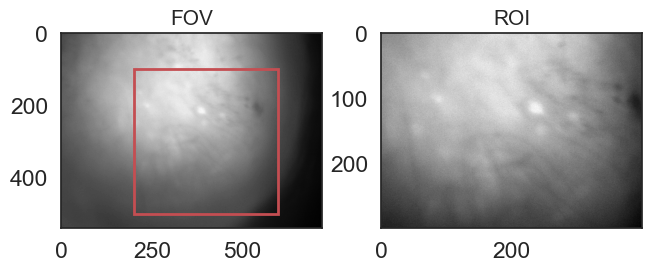

In [34]:
# image visualization
cropped_region_fig_path = 'imgs/FOV_calcium_video_1.png'       #path where the image will be saved

aux.plot_FOV(FOV_file = input_tif_file_path_FOV , ROI_file = input_tif_file_path, 
                             output_file = cropped_region_fig_path)

For any process that tries to separate neurons from background it is important to take into account that the statistics of regions with neurons will be remarkably different from the statistics of regions with no neurons. With  1-photon imaging this is diffuse because background also includes activity from neurons in other focal planes (as explained above). 

### Summary images
---

Summary images are simplification of the videos that gives information about the entire video statistics in one single frame. They are use for computing metrics about the video (quality of motion correction) or also, in the case of CNMF-E (the algorithm we will use), as seed inicialization for source extraction algorithm. 

The most used summary images are:

- **Mean image** : compute the temporal mean of the entire ROI and create one average image.
- **Correlation image**: for every pixel compute the correlation over time with it four (or more) nearest neightbors and compute the mean over that correlation value (this is the pixel value of each pixel in the correlation summary image). With this definition pixels corresponding to the same cell that has the same actitity and changes in luminosity will be more highly correlated while pixels belonging to the background will be less correlated (will see an example in further seccions).
- **Peak to Noise Ratio (PNR)**: computes te the peak to noise ratio pixel by pixel.

In [18]:
###load movie
original_movie = cm.load(input_tif_file_path)
mean_image = cm.summary_images.mean_image(input_tif_file_path)
correlation_image,pnr_image = cm.summary_images.correlation_pnr(original_movie,swap_dim=False)

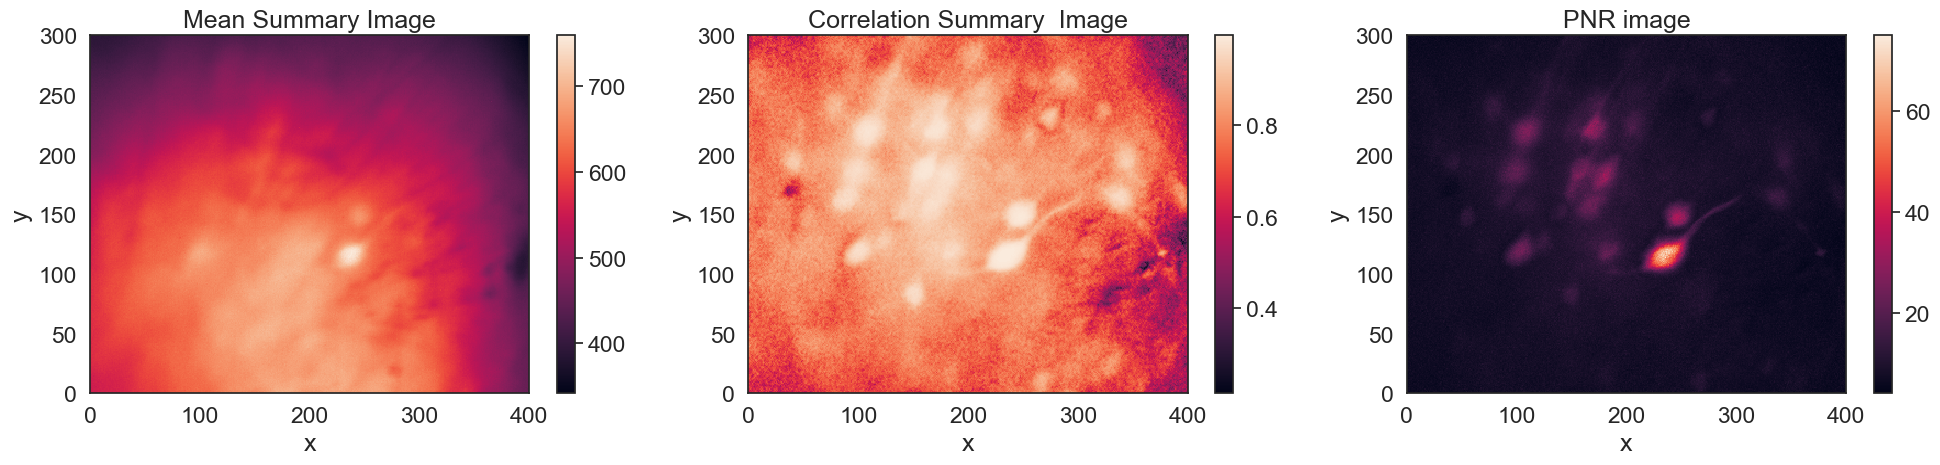

In [35]:
## plotting code is provided for once the mean and correlation summary images are computed
figure, axes = plt.subplots(1,3)
figure.set_size_inches(20,5)

axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Mean Summary Image')

axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Correlation Summary  Image')

axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('PNR image')

mesh0 = axes[0].pcolormesh(mean_image)
mesh1 = axes[1].pcolormesh(correlation_image)
mesh2 = axes[2].pcolormesh(pnr_image)

figure.colorbar(mesh0,ax=axes[0])
figure.colorbar(mesh1,ax=axes[1])
figure.colorbar(mesh2,ax=axes[2])


plt.tight_layout()

### Motion correction (MC)
---
Videos recorded in experimental settings move around: respiration, microscopes movements or the movements from the animal itself all contribute to a non-stationary field of view. 
This means that it is necessary to correct for the motion and align the video to a common frame. 

Here we will use **NoRMCorre**, the motion correction algorithm that is implemented in the CaImAn pipeline. 

We will look both at *rigid motion correction* and *non-rigid (piece-wise) motion correction*: 

In *rigid motion correction* all frames are aligned to a template using a displacement vector. The displacement vector is computed by computing the maximum cross-correlation value between each frame and the template. 

*PW-rigid (piece-wise-rigid) motion correction* consists in splitting the FOV into overlapping patches and perform the correction in each patch. The final correction is computed by using a smooth motion field created by all patches' displacement vectors. 

In practice, an effective approach to motion correction is to first run rigid motion correction to correct for 'big' displacements of the field of view, and then run non-rigid motion correction to get rid of local displacements.

#### MC algorithm parameters

Motion correction requires a general set of parameters definition that are an input to the algorithm. 

The first step into correction motion is to high pass filter the images (smoothing borders): *gSig_filt* . The size of the filter will affect how smooth or sharp the borders of different parts of the image are define. Small filter size will result in multiple images that has lower pixel by pixel correlation values, while big filter size can oversmooth the image to the point where everything will be highly correlated. This is one paremeter to optimize when runnin motion correction and depends on the size in pixels of a typical neuron.

For rigid motion correlation the complete frame will be shift in a *xy* direction. This shift should be limited, as for example, there could be high cross-correlation between in one frame and the mean towards some direction because of highly correlated co-activated neurons that are 'highly' spatialy separated. The limitation for this is imposed by the  *max_shifts* parameter. Similar criteria applyes for non-rigid motion correction, where in this case the limitation is in number of pixels the patch can be shifted from the rigid version (*max_deviation_rigid*). 

For non-rigid motion correction size of patches and overlapping between different patches should be define, ie *strides* and *overlaps*.

For more information about motion correction algorithm see [Pnevmatikakis et al,2017](https://www.sciencedirect.com/science/article/pii/S0165027017302753) *NoRMCorre: An online algorithm for piecewise rigid motion correction of calcium imaging data*.


In [87]:
# We create them in a dictionary to prepare for caiman paramenter requirements

parameters_motion_correction = { 'pw_rigid': True,  # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 
                                'use_cuda': False, 
                                'nonneg_movie': True,
                                'border_nan': 'copy'}


# load tif movie as a caiman movie object
original_movie = cm.load(input_tif_file_path)
# Calculate movie minimum to subtract from movie (this is necesary for running motion correction)
min_mov = np.min(original_movie)
# Add the minumum to the parameter dictionary 
parameters_motion_correction['min_mov'] = min_mov

# pass parameters to caiman object
opts = params.CNMFParams(params_dict = parameters_motion_correction)

To run the pipeline, we start a CaImAn cluster instance

In [88]:
n_processes = psutil.cpu_count() # counts local cpus
cm.cluster.stop_server() #stop any already running clusters
dview.terminate()
# Start a new cluster
c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                 n_processes=n_processes,
                                                 single_thread=False)

We now run the motion correction algorithm in two steps: 
- first perform *rigid motion correction* 
- then we perform *pw-rigid motion correction*. 

The object *mc* will contain the motion correction movie and all the relevant information (for example *mc.x_shifts* contains information about the rigid shifts that were perform along the x axis of the image frame by frame, as will *mc.y_shifts* for the y-axis. 

In [94]:
#make directory to save motion corrected videos
Path("data/motion_corrected").mkdir(parents=True, exist_ok=True)

#create an object for motion correction
mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))
# Perform rigid motion correction
mc.motion_correct_rigid(save_movie = True, template = None)

#perform non-rigid motion correction
total_template_rig = mc.total_template_rig
mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
fname_tot_els = mc.fname_tot_els[0]

#reshape memmap files for source extraction

#m_els = cm.load(fname_tot_els)
#m_els.save(fname_tot_els,  order='C')



In [95]:
m_els = cm.load(fname_tot_els)
fname_tot_els  = m_els.save('motion_corrected_video.mmap',  order='C')
#os.remove(mc.fname_tot_els[0])

In [96]:
# play original video, rigid motion corrected and pw motion corrected
# concatenate the three movies along axes 2
m_rig = cm.load(mc.fname_tot_rig)
m_els = cm.load(mc.fname_tot_els)


gain = 1
magnification = 1
fr = 10
movies_chained = cm.concatenate([original_movie,m_rig,m_els],axis = 2).resize(1,1,.5).play(gain = gain, magnification = magnification, fr = fr)

100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


#### Evaluating motion correction quality

How good is our motion correction? 
There are different measurements that can be used to evaluate the performance of the motion correction algorithm,as discussed in detail in[Pnevmatikakis et al. 2017](https://www.sciencedirect.com/science/article/pii/S0165027017302753).

A simple quality measure is *crispness*. Crispness is computed directly on the summary images (mean image or correlation image), by computing the norm of the gradient field of the image at all pixels. 
If SI is the summary image then its crispness is defined as 

$$C(SI) = ∥ | ∇SI | ∥_F $$


where $ ∇I $ denotes the gradient vector field of $I$ in all directions, $|·|$ denotes the entry-wise magnitude, and $ ∥·∥_F $ denotes the Frobenius norm.  
Lower values of crispness means higher intrinsic motion (the image is more blurred).  
Higher values of crispness means there are sharp transition borders, which mean a more stationary video.

There are more sophisticated measures that can be used to quantify the quality of the motion correction, taking into account the complete motion field of the video, that we won't be covering in details here, but can be found in the original paper referenced above.

In [ ]:
#crispness calculation

<div class="alert alert-block alert-info">

### PARAMETERS OF THE MOTION CORRECTION ALGORITHM

The quality of motion correction will depend on the parameters we selected. If crispness values after motion correction are improved, that could mean that the parameters used for motion correction were not optimal, and the algorithm deteriorated the image.
In the above example some parameters could not optimal for motion correction in this particular video. For the example we used one selected value of the filter, but the performance of the motion correction algorithm will be dependent on the quality of the image that comes out from that filter and how blurry that image is.

## ELABORATE NOTE

### Source extraction
---

Original algorithms to perform source extraction from calcium videos were based on **PCA** and **ICA**. The disadvantage of appying this techniques directly is that they do not confine the sources to only one spatial region nor does provide good solution to deal with overlapping sources. As we are using CaImAn, in this notebook we will use a different technique called *Constrained Non-Negative Matrix Factorization* (**CNMF**). This technique (as non linear) solves the sparcity problem by adding multiple constrains to an optimation problem and also can deal better with overlapping sources. 

Matrix factorization part is based on the fact that a calcium imaging video can be  can be approximated as a product of two matrices: a spatial matrix (**A**) that encodes the location of each neuron in the optical field, and a temporal matrix (**C**) that characterizes the calcium concentration evolution of each neuron. This deconvolution can be constrained to the fact that spiking activity and the shape of each inferred neuron are as sparce as posible. 

The recorded video data can be represented by a matrix $Y∈R^{d×T}$, where $d$ is the number of pixels in the field of view and $T$ is the number of frames observed. Each neuron $i$ is characterized by its spatial *‘footprint’* vector $a_i ∈R^{d}$ characterizing the cell’s shape and location, and *‘calcium activity’* timeseries $c_i∈R^T$, modeling (up to a multiplicative and additive constant) cell i’s mean fluorescence signal at each frame. Here, both $a_i$ and $c_i$ are constrained to be nonnegative because of their physical interpretations. The background fluctuation is represented by a matrix $B∈R^{d×T}$. If the field of view contains a total number of K neurons, then the observed movie data is modeled as a superposition of all neurons’ spatiotemporal activity, plus time-varying background and additive noise:


$$ Y = \sum_{i=1..K} a_i . c_i^T + B + E = A C + B + E $$

where $A=[a_1,…,a_K]$ and $C=[c_1,…,c_K]^T$. The noise term $E∈R^{d×T}$ is modeled as Gaussian, $E(t)∼N(0,Σ)$ is a diagonal matrix, indicating that the noise is spatially and temporally uncorrelated.

Estimating the model parameters A,C in the model gives us all neurons’ spatial footprints and their denoised temporal activity. This can be achieved by minimizing the residual sum of squares (RSS), aka the Frobenius norm of the matrix Y−(AC+B),

$$ ∥Y−(AC+B)∥_F $$

while requiring the model variables A,C and B to follow the desired constraints, discussed above.

For more information about deconvolution methods see [Pnevmatikakis, et al. 2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4881387/) *Simultaneous Denoising, Deconvolution, and Demixing of Calcium Imaging Data*.


More information about the background modeling for microendoscopic data can be found in [Pengcheng Zhou, et al. 2018](https://elifesciences.org/articles/28728) *Efficient and accurate extraction of in vivo calcium signals from microendoscopic video data*.


More information about **CaImAn** complete pipeline can be found in [Andrea Giovannucci, et al. 2019](https://elifesciences.org/articles/38173) *CaImAn an open source tool for scalable calcium imaging data analysis*



In [97]:
# load motion corrected video
input_mmap_file_path = 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500_.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

In [98]:
# compute correlation and pnr images 
gSig = 9
corr_image, pnr_image = cm.summary_images.correlation_pnr(images[::1], gSig=gSig,swap_dim=False)

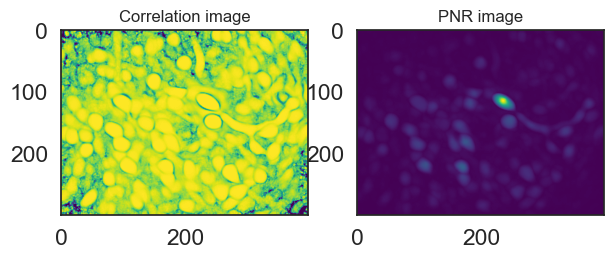

In [99]:
aux.summary_images(corr_image = corr_image, pnr_image = pnr_image)

Here we will run an example on the video we have been working on for source extraction. First we will define some fixed parameters for this example and later we will explore the impact of those in the source extraction output (particularly the seeds for inicialization in CNMF-E).

In [100]:
# create dictionary with source extraction parameters

parameters_source_extraction ={ 'fr': 10,               # movie frame rate
                               'decay_time': 0.1,       # length of a typical transient in seconds
                               'min_corr': 0.7,   # min peak value from correlation image
                               'min_pnr': 7,     # min peak to noise ration from PNR image
                                'p': 1,                # order of the autoregressive system 
                               'K': None,              # upper bound on number of components per patch, in general None
                               'gSig': (4, 4),         # gaussian width of a 2D gaussian kernel, which approximates a neuron
                               'gSiz': (17, 17),       # average diameter of a neuron, in general 4*gSig+1
                               'ring_size_factor': 1.4, # radius of ring is gSiz*ring_size_factor
                               'merge_thr': 0.7, 'rf': 60,
                               'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                               'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2,
                               'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                               'update_background_components': True,
                               'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                               'del_duplicates': True, 'only_init': True}
# create caiman parameters objects
opts = params.CNMFParams(params_dict=parameters_source_extraction)

In [102]:
cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
cnmf_object.fit(images)

/Users/davide/opt/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/davide/opt/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/davide/opt/anaconda3/envs/caiman/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged 

In [103]:
# Save the cnmf object as a hdf5 file
Path("data/source_extracted").mkdir(parents=True, exist_ok=True)
output_cnmf_file_path = 'data/source_extracted/calcium_video_0_cnmf.hdf5'
cnmf_object.save(output_cnmf_file_path)

The outputs from CNMF are 
- **A**: a matrix  containing the footprints, accessible as `cnmf_object.estimates.A`
- **C** a matrix containing the temporal calcium traces, in `cnmf_object.estimates.C`. 

Let's look at the reults: we plot footprints on top on the correlation image, and the extracted temporal traces.


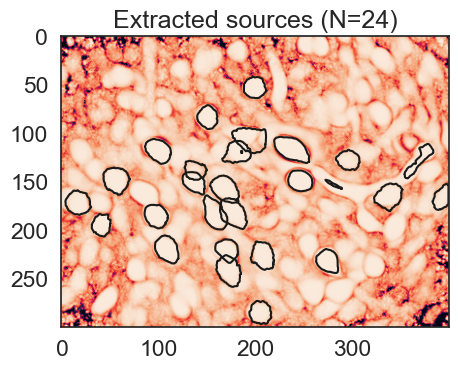

In [110]:
# display footprints in the ROI
figure, axes = plt.subplots(1,figsize=(5,5))
plt.title(f'Extracted sources (N={cnmf_object.estimates.A.shape[1]})')
pos = axes.imshow(corr_image)
coordinates = cm.utils.visualization.get_contours(cnmf_object.estimates.A, np.shape(corr_image), 0.2, 'max')
for c in coordinates:
    v = c['coordinates']
    c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                    np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
    axes.plot(*v.T, c='k')


Text(0, 0.5, 'activity')

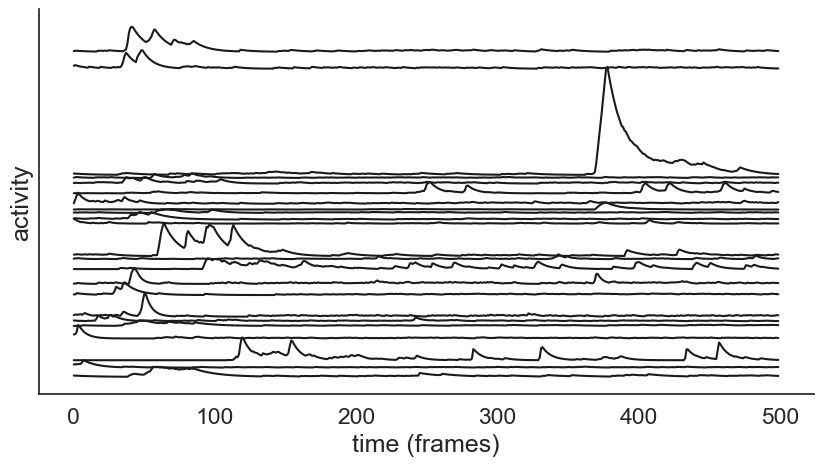

In [118]:
# plot temporal traces
figure, axes = plt.subplots(1,figsize=(10,5))
C_0 = cnmf_object.estimates.C.copy()
C_0[1] += C_0[0].min()
for i in range(1, len(C_0)):
    C_0[i] += C_0[i].min() + C_0[:i].max()
    axes.plot(C_0[i],c='k')
axes.set_xlabel('time (frames)')
axes.set_yticks([])
sns.despine()
axes.set_ylabel('activity')


<div class="alert alert-block alert-info">

### PARAMETERS OF THE SOURCE EXTRECTION ALGORITHM

There are many parameters involved in the source extraction algorithm but we will concentrate on the impact of two of them, *min_corr* and *min_pnr*, that are the seed for the 1p source extraction algorithm. 

Computation of source extraction is slow, and here we will run it multiple times, so ***be patient***.

You can change the *corr_values* and *pnr_values* range, but take into account that the lower those values are, the most permissive the conditions for select a region as a cell is. This will increase the number of cells that are detected but will also slow down the extraction algorithm. If you are having speed problems you can also try increasing the range of values of corr and pnr, which will result in a lower number of components detected.

## ELABORATE NOTE

### Component evaluation
---


In [ ]:
# code

## Further steps
---
- Component registration
- Photobleaching
- spikes deconvolution

### Extracting spike counts with deconvolution
---


### Matching cells across sessions
---


<div class="alert alert-block alert-info">


### Key points 

- The main steps of the preprocessing pipeline are: motion correction, source extraction, source evaluation,
cell registration and trace deconvilution.
- It's important to monitor the quality fo the data. Useful metrics for that are *summary images*, *image metrics* (such as cripspness).

<div class="alert alert-block alert-info">


### References and resources

**Books & papers**
* Book 1

**Websites & blogposts**
* syte one

**Software**
* library 1



## Exercises
You can find the exercises for this lessons in [exercises.ipynb](exercises.ipynb)